In [34]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from datetime import datetime 
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
# %matplotlib inline 
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

In [3]:
df = pd.read_csv(r'/Users/malachihale/codeup-data-science/time-series-exercises/GlobalLandTemperaturesByState.csv')

In [4]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


In [5]:
df = df[df.State == "Texas"]

In [6]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
549727,1820-01-01,4.489,3.369,Texas,United States
549728,1820-02-01,9.081,2.873,Texas,United States
549729,1820-03-01,12.657,2.423,Texas,United States
549730,1820-04-01,19.215,2.501,Texas,United States
549731,1820-05-01,22.577,2.495,Texas,United States


In [7]:
df.tail()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
552047,2013-05-01,22.628,0.158,Texas,United States
552048,2013-06-01,27.841,0.220,Texas,United States
552049,2013-07-01,27.630,0.182,Texas,United States
552050,2013-08-01,28.663,0.247,Texas,United States
552051,2013-09-01,26.408,1.112,Texas,United States


For the sake of data integrity, we will check that all of our Texas data is also in the United States. 

In [8]:
df[df.Country != "United States"]

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country


All of our data points are located in the United States.

In [9]:
def prep_data(df):
    # Reassign the sale_date column to be a datetime type
    df['date'] = pd.to_datetime(df.dt)
    
    # Sort rows by the date and then set the index as that date
    df = df.set_index("date").sort_index()
    
    df = df.drop(columns = ["dt"])
    
    return df

In [10]:
df = prep_data(df)

In [11]:
df.head(3)

,AverageTemperature,AverageTemperatureUncertainty,State,Country
date,,,,
1820-01-01,4.489,3.369,Texas,United States
1820-02-01,9.081,2.873,Texas,United States
1820-03-01,12.657,2.423,Texas,United States


In [12]:
df.tail(3)

,AverageTemperature,AverageTemperatureUncertainty,State,Country
date,,,,
2013-07-01,27.630,0.182,Texas,United States
2013-08-01,28.663,0.247,Texas,United States
2013-09-01,26.408,1.112,Texas,United States


In [13]:
df = df.groupby(['date'])[['AverageTemperature', 'AverageTemperatureUncertainty']].sum()

In [14]:
df.head(3)

,AverageTemperature,AverageTemperatureUncertainty
date,,
1820-01-01,4.489,3.369
1820-02-01,9.081,2.873
1820-03-01,12.657,2.423


## Split Data

In [15]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

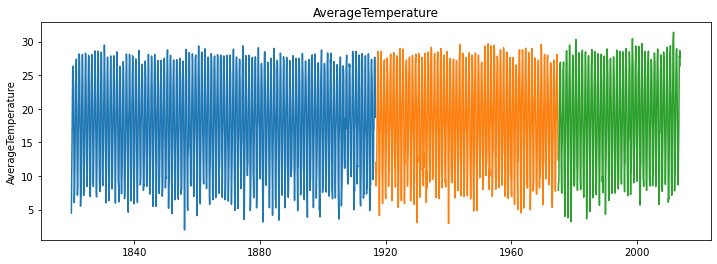

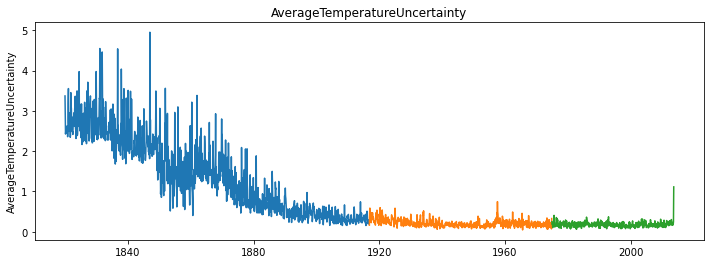

In [16]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

## Evalute of Functions

In [17]:
# evaluation function to compute rmse

def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [18]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [19]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [20]:
eval_df

,model_type,target_var,rmse


## Forecast

### Simple Average

In [22]:
AverageTemperature = train['AverageTemperature'].mean()
AverageTemperatureUncertainty = train['AverageTemperatureUncertainty'].mean()

def make_predictions():
    yhat_df = pd.DataFrame({'AverageTemperature': [AverageTemperature], 
                           'AverageTemperatureUncertainty': [AverageTemperatureUncertainty]}
                           , index = validate.index)
    return yhat_df

yhat_df = make_predictions()

In [23]:
yhat_df.head()

,AverageTemperature,AverageTemperatureUncertainty
date,,
1916-11-01,17.829652,1.391718
1916-12-01,17.829652,1.391718
1917-01-01,17.829652,1.391718
1917-02-01,17.829652,1.391718
1917-03-01,17.829652,1.391718


AverageTemperature -- RMSE: 7


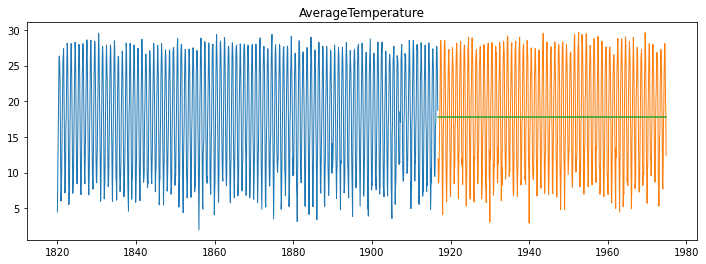

AverageTemperatureUncertainty -- RMSE: 1


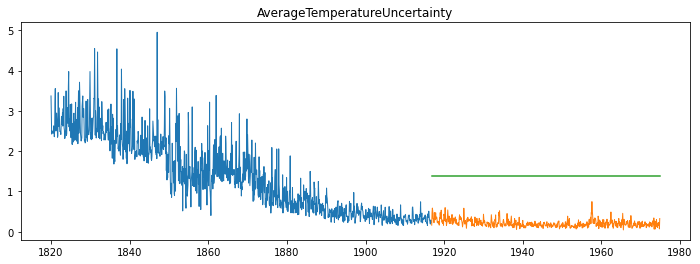

In [24]:
for col in train.columns:
    plot_and_eval(col)

In [25]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

In [26]:
eval_df

,model_type,target_var,rmse
0,simple_average,AverageTemperature,7.0
1,simple_average,AverageTemperatureUncertainty,1.0


### Moving Average

In [27]:
period = 3

AverageTemperature = train['AverageTemperature'].rolling(period).median().iloc[-1]
AverageTemperatureUncertainty = train['AverageTemperatureUncertainty'].rolling(period).median().iloc[-1]

yhat_df = make_predictions()
yhat_df.head(3)

,AverageTemperature,AverageTemperatureUncertainty
date,,
1916-11-01,23.658,0.281
1916-12-01,23.658,0.281
1917-01-01,23.658,0.281


AverageTemperature -- RMSE: 9


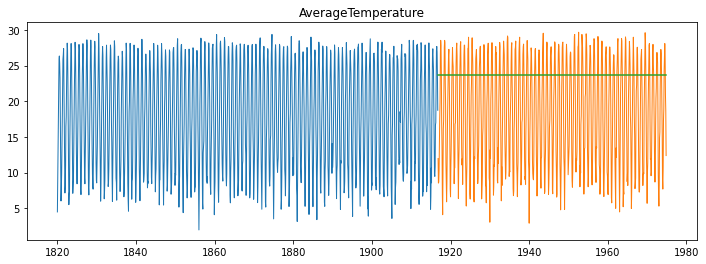

AverageTemperatureUncertainty -- RMSE: 0


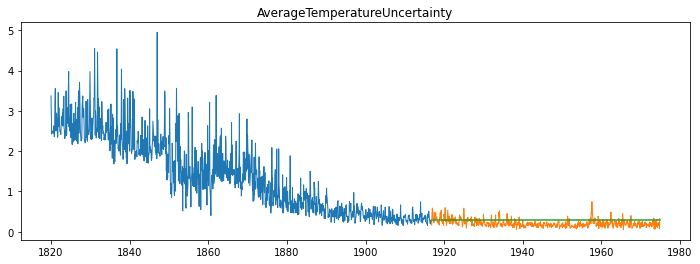

In [28]:
for col in train.columns:
    plot_and_eval(col)

In [29]:
for col in train.columns:
    eval_df = append_eval_df(model_type='3 month moving average', 
                             target_var = col)

In [30]:
periods = [1, 4, 8, 12, 24]

for p in periods:
    AverageTemperature = train['AverageTemperature'].rolling(period).median().iloc[-1]
    AverageTemperatureUncertainty = train['AverageTemperatureUncertainty'].rolling(period).median().iloc[-1]

    yhat_df = make_predictions()
    model_type = str(p) + ' month moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'AverageTemperature')
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'AverageTemperatureUncertainty')

In [31]:
eval_df

,model_type,target_var,rmse
0,simple_average,AverageTemperature,7.0
1,simple_average,AverageTemperatureUncertainty,1.0
2,3 month moving average,AverageTemperature,9.0
3,3 month moving average,AverageTemperatureUncertainty,0.0
4,1 month moving average,AverageTemperature,9.0
5,1 month moving average,AverageTemperatureUncertainty,0.0
6,4 month moving average,AverageTemperature,9.0
7,4 month moving average,AverageTemperatureUncertainty,0.0
8,8 month moving average,AverageTemperature,9.0
9,8 month moving average,AverageTemperatureUncertainty,0.0


### Holt's Linear Trend

AverageTemperature 



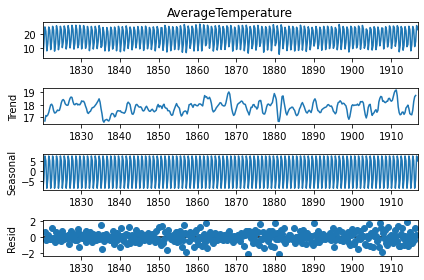

AverageTemperatureUncertainty 



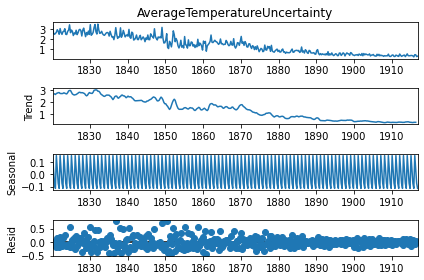

In [32]:
import statsmodels.api as sm

for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('3M').mean()).plot()
    plt.show()

In [35]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

AverageTemperature -- RMSE: 102


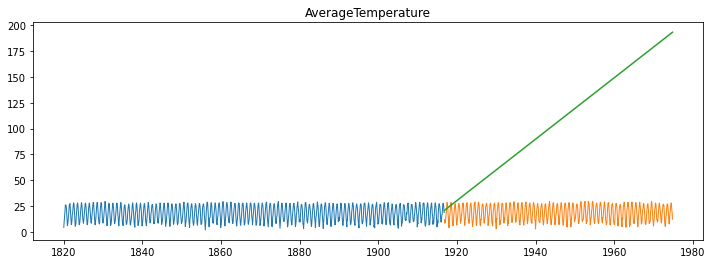

AverageTemperatureUncertainty -- RMSE: 1


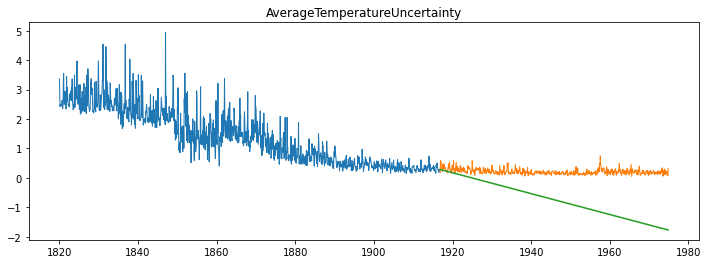

In [36]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [37]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)

In [38]:
eval_df

,model_type,target_var,rmse
0,simple_average,AverageTemperature,7.0
1,simple_average,AverageTemperatureUncertainty,1.0
2,3 month moving average,AverageTemperature,9.0
3,3 month moving average,AverageTemperatureUncertainty,0.0
4,1 month moving average,AverageTemperature,9.0
5,1 month moving average,AverageTemperatureUncertainty,0.0
6,4 month moving average,AverageTemperature,9.0
7,4 month moving average,AverageTemperatureUncertainty,0.0
8,8 month moving average,AverageTemperature,9.0
9,8 month moving average,AverageTemperatureUncertainty,0.0
